## Downloading the dataset from kaggle

In [1]:
!pip install opendatasets -q

In [2]:
import opendatasets as od

DATASET_URL = "https://www.kaggle.com/competitions/quora-question-pairs/data"

# downloading the dataset
od.download(DATASET_URL)

100%|██████████| 309M/309M [00:01<00:00, 164MB/s]



Extracting archive ./quora-question-pairs/quora-question-pairs.zip to ./quora-question-pairs


In [3]:
# unzip the training files

import shutil

# Specify the path and filename of the zip file
zip_file = '/content/quora-question-pairs/train.csv.zip'

# Specify the destination directory where the files will be extracted
destination_folder = '/content/training_data'

# Unzip the files
shutil.unpack_archive(zip_file, destination_folder)


## EDA

In [4]:
# importing the packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

In [5]:
# loading the dataset into pandas dataframe 
TRAINING_FILE_PATH = './training_data/train.csv'

df = pd.read_csv(TRAINING_FILE_PATH)
print(f"Shape of the dataset: {df.shape}\n")

# Taking 30000 sample dataset to ease burden on RAM 
new_df = df.sample(30000, random_state=2)

# random 5 rows from the dataset 
new_df.sample(5)

Shape of the dataset: (404290, 6)



,id,qid1,qid2,question1,question2,is_duplicate
277828,277828,397007,397008,How much does it cost to get hypnotized to qui...,How much does it cost to quit smoking using ni...,0
397313,397313,530427,411354,What is the craziest thing you have ever done ...,What is the craziest things ever done?,0
260858,260858,376868,59325,How do I pass drug test for meth?,How long does meth stay detectable in the body...,0
358465,358465,487959,487960,Who knew about what was going on between Jaime...,Which characters in Game of Thrones know about...,1
20278,20278,38270,38271,What are some mind-blowing mobile inventions t...,What are some mind blowing phone tech Inventio...,1


In [6]:
# checking the null values in the dataset 
new_df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [7]:
# checking for duplicated rows in the dataset 
new_df.duplicated().sum()

0

Distribution of duplicated and non-duplicated values:
0    19013
1    10987

Distribution of duplicated and non-duplicated values in percentage:
0    63.376667
1    36.623333



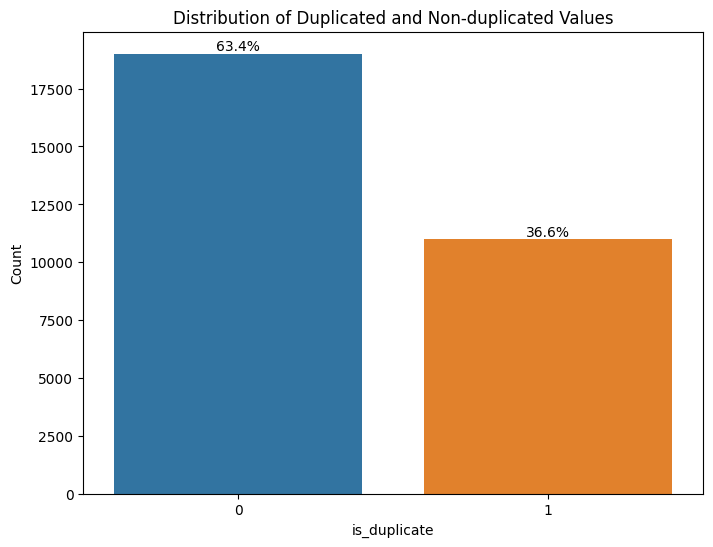

In [8]:
# Distribution of duplicated and non-duplicated values 
print(f"Distribution of duplicated and non-duplicated values:\n{new_df['is_duplicate'].value_counts().to_string()}\n")

percentage_distribution = (new_df['is_duplicate'].value_counts()/new_df['is_duplicate'].count())*100
print(f"Distribution of duplicated and non-duplicated values in percentage:\n{percentage_distribution.to_string()}\n")

# Create the countplot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='is_duplicate', data=new_df)

# Add percentage labels to the bars
total = len(new_df['is_duplicate'])
for p in ax.patches:
    percentage = '{:.1f}%'.format((p.get_height() / total) * 100)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

# Set plot title and labels
plt.title("Distribution of Duplicated and Non-duplicated Values")
plt.xlabel("is_duplicate")
plt.ylabel("Count")

# Show the plot
plt.show()


In [9]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q
    

In [10]:
preprocess("I've already! wasn't <b>done</b>?")

'i have already  was not done'

In [11]:
# applying the preprocess function on 'question 1' and 'question_2' in 'new_df' and saving it in 'new_df'
new_df['question1'] = new_df['question1'].apply(preprocess) 
new_df['question2'] = new_df['question2'].apply(preprocess) 

In [12]:
# checking the dataset after applying the preprocessing 
new_df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
80291,80291,136515,136516,how do i snap more than 10 seconds on snapchat,is it possible to use multiple snapchat accoun...,0
288870,288870,63450,63476,what should i do to beat loneliness,how do i tackle extreme loneliness,1
309745,309745,433778,433779,what is the best handbook for mechanical engin...,what is the best handbook for mechanical engin...,1
334661,334661,461855,461856,what is conservation economy,what is a conservative,0
336438,336438,463798,463799,how often do criminals in the us turn themselv...,are criminals that end up in jail at peace wit...,0


In [13]:
# repeated questions 
qid = pd.Series(new_df['qid1'].tolist() + new_df['qid2'].tolist())
print(f"Number of unique questions based on question id: {np.unique(qid).shape[0]}")

# questions repeated more than once 
x = qid.value_counts() > 1
print(f"Number of quiestion getting repearted: {x[x].shape[0]}")

Number of unique questions based on question id: 55299
Number of quiestion getting repearted: 3480


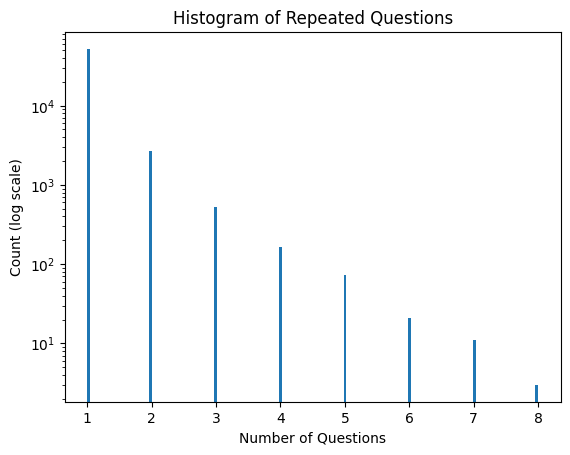

In [14]:
# Repeated questions histogram
plt.hist(qid.value_counts().values,bins=160)
plt.yscale('log')

plt.title("Histogram of Repeated Questions")
plt.xlabel("Number of Questions")
plt.ylabel("Count (log scale)")
plt.show()

## Feature Enginerring

In [15]:
# calculating the length of the questions 
# adding it as an input feature in dataset 

new_df['q1_len'] = new_df['question1'].str.len()
new_df['q2_len'] = new_df['question2'].str.len()

In [16]:
# calculating the number of words in questions 
# adding it as an input feature in the dataset 

new_df['q1_num_words'] = new_df['question1'].apply(lambda row: len(row.split(" ")))
new_df['q2_num_words'] = new_df['question2'].apply(lambda row: len(row.split(" ")))

# checking 5 random samples from the dataset
new_df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words
319372,319372,11055,4433,what must i do to have good handwriting,how i can be good at handwriting,1,39,32,8,7
39300,39300,71267,71268,who has more fans in tamil nadu ajith or vijay,why do not vijay and ajith advise their fans n...,0,47,77,11,16
395210,395210,528168,528169,what are some of the best chinese tv dramas,what are some of the best cantonese language w...,0,43,60,9,11
82288,82288,139557,139558,how does codeine show up on urine test,how can cocaine show up on my urine test if i ...,0,38,62,8,15
114766,114766,187282,187283,is ndtv a biased news channel,why can not biased news channels like ndtv be ...,0,29,52,6,10


In [17]:
SAMPLE_TEXT = new_df[new_df['id']==153007]['question1'].tolist()[0]

print(f"Sample text:\n{SAMPLE_TEXT}\n")

print(f"Lenght of the sample text:\n{len(SAMPLE_TEXT)}\n")

print(f"Number of words in Sample text:\n{len(SAMPLE_TEXT.split(' '))}")

Sample text:
how can you find the purpose of human life

Lenght of the sample text:
42

Number of words in Sample text:
9


In [18]:
# finding the number of common words in two questions
def common_words(row):
  w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(' ')))
  w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(' ')))
  return len(w1 & w2)

In [19]:
SAMPLE_TEXT_01 = new_df[new_df['id']==153007]['question1'].tolist()[0]
SAMPLE_TEXT_02 = new_df[new_df['id']==153007]['question2'].tolist()[0]

# taking text or row as an input, convert the question to lower case, strip the blank splaces, and split the words
w1 = set(map(lambda word: word.lower().strip(), SAMPLE_TEXT_01.split(' '))) 
w2 = set(map(lambda word: word.lower().strip(), SAMPLE_TEXT_02.split(' ')))

print(f"Sample text #01:\n{SAMPLE_TEXT_01}\n")
print(f"Unique words in Sample text #01\n{w1}\n")

print(f"Sample text #02:\n{SAMPLE_TEXT_02}\n")
print(f"Unique words in Sample text #02\n{w2}")

print(f"\nUnique words common in both questions\n{w1 & w2}\ncount of words:{len(w1&w2)}")

Sample text #01:
how can you find the purpose of human life

Unique words in Sample text #01
{'of', 'the', 'find', 'how', 'purpose', 'can', 'human', 'you', 'life'}

Sample text #02:
how do i find a basic purpose in my life

Unique words in Sample text #02
{'basic', 'in', 'find', 'how', 'purpose', 'i', 'my', 'a', 'do', 'life'}

Unique words common in both questions
{'find', 'how', 'purpose', 'life'}
count of words:4


In [20]:
# applying common word function to the dataframe and adding as an input feature
new_df['word_common'] = new_df.apply(common_words, axis=1)

# checking 5 random samples from the dataset 
new_df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common
302917,302917,425977,425978,what is the description of dorian gray,what do you think about the picture of dorian...,0,38,51,7,11,5
221105,221105,328358,328359,i have serve 1 month notice period instead o...,am i suitable to be a cook what qualities sho...,0,102,61,22,14,3
102167,102167,169081,169082,what would robert pattinson be doing if he wer...,eva longoria what would you do if you were no...,0,60,58,12,13,6
329366,329366,456008,456009,what were some of your worst stock investments...,what were some your best stock investments an...,0,73,69,15,14,13
399752,399752,512798,265312,which is the best place to shop in mumbai for ...,what is the best place to eat street food in m...,0,83,51,17,11,8


In [21]:
# calculating total unique words per question and adding them and creating one new input feature
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

In [22]:
new_df['word_total'] = new_df.apply(total_words, axis=1)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,12,26
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,8,24
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,4,38
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,1,34
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3,13


In [23]:
SAMPLE_TEXT_01 = new_df[new_df['id']==398782]['question1'].tolist()[0]
SAMPLE_TEXT_02 = new_df[new_df['id']==398782]['question2'].tolist()[0]
print(f"Sample text #01:\n{SAMPLE_TEXT_01}")
print(f"\nSample text #02:\n{SAMPLE_TEXT_02}")

WORD_COMMON = new_df[new_df['id']==398782]['word_common'].tolist()[0]
WORD_TOTAL = new_df[new_df['id']==398782]['word_total'].tolist()[0]
print(f"\nCommon word count: {WORD_COMMON}")
print(f"\nTotal word count: {WORD_TOTAL}")

WORD_SHARE = WORD_COMMON/WORD_TOTAL

print(f"\nword share in the given two text:{round(WORD_SHARE, 2)}")

Sample text #01:
what is the best marketing automation tool for small and mid size companies

Sample text #02:
what is the best marketing automation tool for small and mid sized companies

Common word count: 12

Total word count: 26

word share in the given two text:0.46


In [24]:
# adding word share value in dataframe as input feature
new_df['word_share'] = round(new_df['word_common']/new_df['word_total'],2)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,12,26,0.46
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,8,24,0.33
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,4,38,0.11
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,1,34,0.03
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3,13,0.23


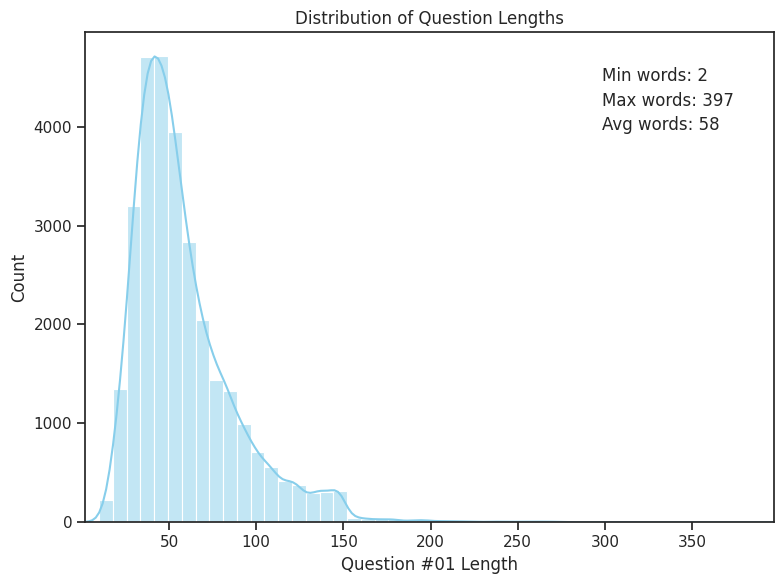

In [25]:
# Create a displot (distribution plot) of question lengths
sns.set(style="ticks")
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(data=new_df, x='q1_len', kde=True, bins=50, color='skyblue')

# Add labels and title
plt.title("Distribution of Question Lengths")
plt.xlabel("Question #01 Length")
plt.ylabel("Count")

# Set x-axis limits based on the data range
plt.xlim(new_df['q1_len'].min(), new_df['q1_len'].max())

# Calculate and display additional information
min_len = new_df['q1_len'].min()
max_len = new_df['q1_len'].max()
avg_len = int(new_df['q1_len'].mean())
plt.text(0.75, 0.9, f"Min words: {min_len}", transform=ax.transAxes)
plt.text(0.75, 0.85, f"Max words: {max_len}", transform=ax.transAxes)
plt.text(0.75, 0.8, f"Avg words: {avg_len}", transform=ax.transAxes)

# Show the plot
plt.tight_layout()
plt.show()


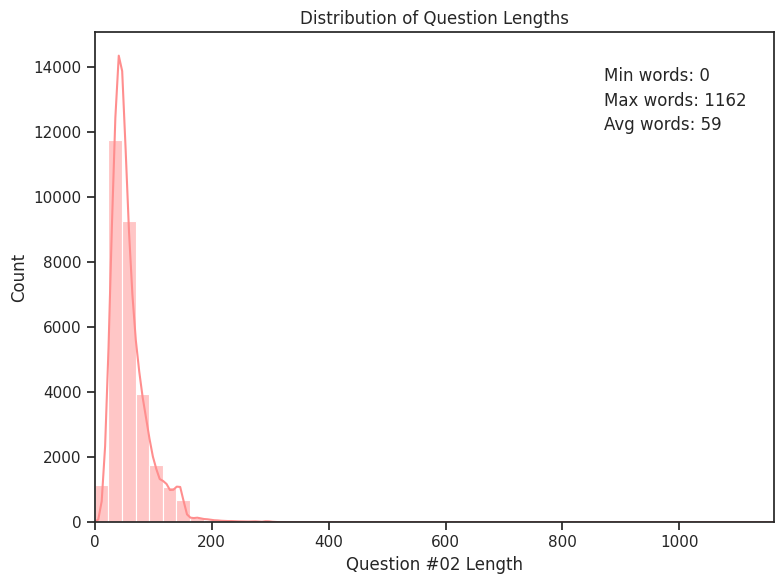

In [26]:
# Create a displot (distribution plot) of question lengths
sns.set(style="ticks")
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(data=new_df, x='q2_len', kde=True, bins=50, color='#FF8E8E')

# Add labels and title
plt.title("Distribution of Question Lengths")
plt.xlabel("Question #02 Length")
plt.ylabel("Count")

# Set x-axis limits based on the data range
plt.xlim(new_df['q2_len'].min(), new_df['q2_len'].max())

# Calculate and display additional information
min_len = new_df['q2_len'].min()
max_len = new_df['q2_len'].max()
avg_len = int(new_df['q2_len'].mean())
plt.text(0.75, 0.9, f"Min words: {min_len}", transform=ax.transAxes)
plt.text(0.75, 0.85, f"Max words: {max_len}", transform=ax.transAxes)
plt.text(0.75, 0.8, f"Avg words: {avg_len}", transform=ax.transAxes)

# Show the plot
plt.tight_layout()
plt.show()


In [27]:
#question #02 where word lenght is 0
from IPython.display import display
print(f"#question #02 where word lenght is 0")
display(new_df[new_df['q2_len']==0])
print(f"\n{'/-/'*50}")

print(f"\nquestion2 content as this cell:'{new_df[new_df['q2_len']==0]['question2'].to_string()}'")
print(f"\nThe cell content is number,hence the word count is 0")

#question #02 where word lenght is 0


,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
384293,384293,516316,37899,how do i solve this,,0,19,0,5,1,0,6,0.0



/-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-//-/

question2 content as this cell:'384293    '

The cell content is number,hence the word count is 0


In [28]:
# removing that rows 
new_df_2 = new_df.drop(new_df[new_df['id']==384293].index)

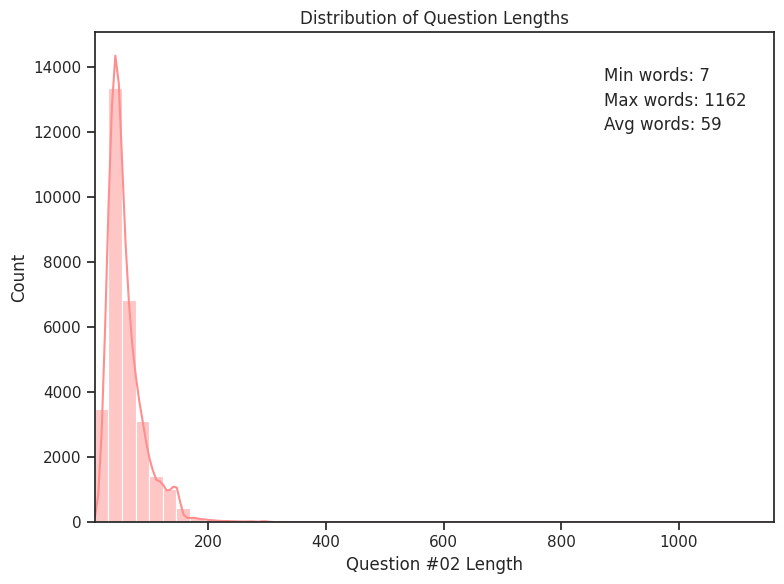

In [29]:
# Create a displot (distribution plot) of question lengths
sns.set(style="ticks")
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(data=new_df_2, x='q2_len', kde=True, bins=50, color='#FF8E8E')

# Add labels and title
plt.title("Distribution of Question Lengths")
plt.xlabel("Question #02 Length")
plt.ylabel("Count")

# Set x-axis limits based on the data range
plt.xlim(new_df_2['q2_len'].min(), new_df_2['q2_len'].max())

# Calculate and display additional information
min_len = new_df_2['q2_len'].min()
max_len = new_df_2['q2_len'].max()
avg_len = int(new_df_2['q2_len'].mean())
plt.text(0.75, 0.9, f"Min words: {min_len}", transform=ax.transAxes)
plt.text(0.75, 0.85, f"Max words: {max_len}", transform=ax.transAxes)
plt.text(0.75, 0.8, f"Avg words: {avg_len}", transform=ax.transAxes)

# Show the plot
plt.tight_layout()
plt.show()


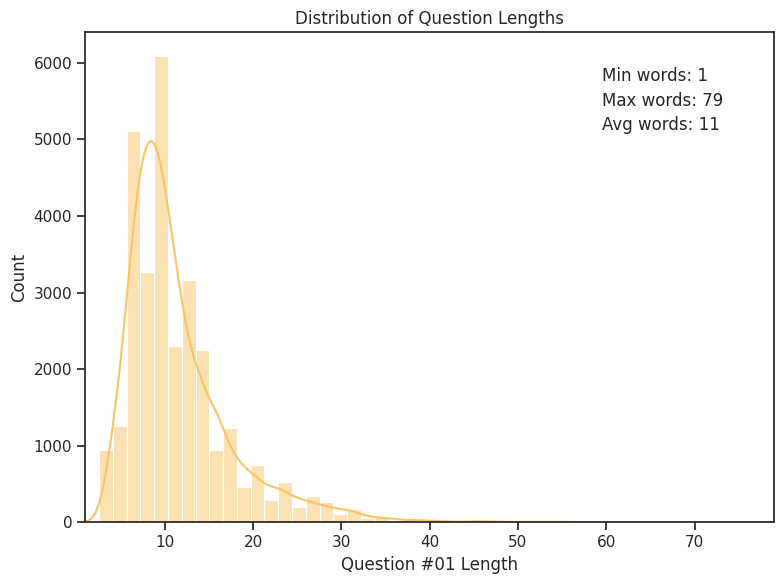

In [30]:
# Create a displot (distribution plot) of question lengths
sns.set(style="ticks")
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(data=new_df, x='q1_num_words', kde=True, bins=50, color='#FBC469')

# Add labels and title
plt.title("Distribution of Question Lengths")
plt.xlabel("Question #01 Length")
plt.ylabel("Count")

# Set x-axis limits based on the data range
plt.xlim(new_df['q1_num_words'].min(), new_df['q1_num_words'].max())

# Calculate and display additional information
min_len = new_df['q1_num_words'].min()
max_len = new_df['q1_num_words'].max()
avg_len = int(new_df['q1_num_words'].mean())
plt.text(0.75, 0.9, f"Min words: {min_len}", transform=ax.transAxes)
plt.text(0.75, 0.85, f"Max words: {max_len}", transform=ax.transAxes)
plt.text(0.75, 0.8, f"Avg words: {avg_len}", transform=ax.transAxes)

# Show the plot
plt.tight_layout()
plt.show()


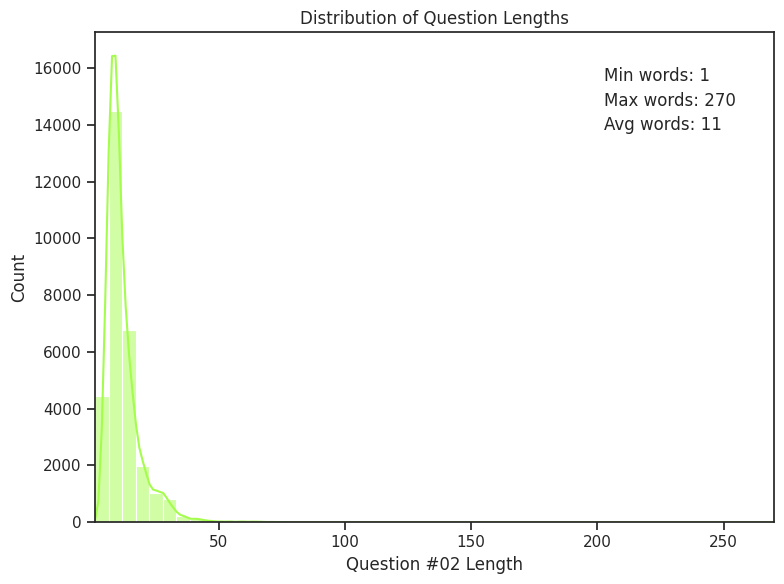

In [31]:
# Create a displot (distribution plot) of question lengths
sns.set(style="ticks")
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(data=new_df, x='q2_num_words', kde=True, bins=50, color='#A4FC4D')

# Add labels and title
plt.title("Distribution of Question Lengths")
plt.xlabel("Question #02 Length")
plt.ylabel("Count")

# Set x-axis limits based on the data range
plt.xlim(new_df['q2_num_words'].min(), new_df['q2_num_words'].max())

# Calculate and display additional information
min_len = new_df['q2_num_words'].min()
max_len = new_df['q2_num_words'].max()
avg_len = int(new_df['q2_num_words'].mean())
plt.text(0.75, 0.9, f"Min words: {min_len}", transform=ax.transAxes)
plt.text(0.75, 0.85, f"Max words: {max_len}", transform=ax.transAxes)
plt.text(0.75, 0.8, f"Avg words: {avg_len}", transform=ax.transAxes)

# Show the plot
plt.tight_layout()
plt.show()


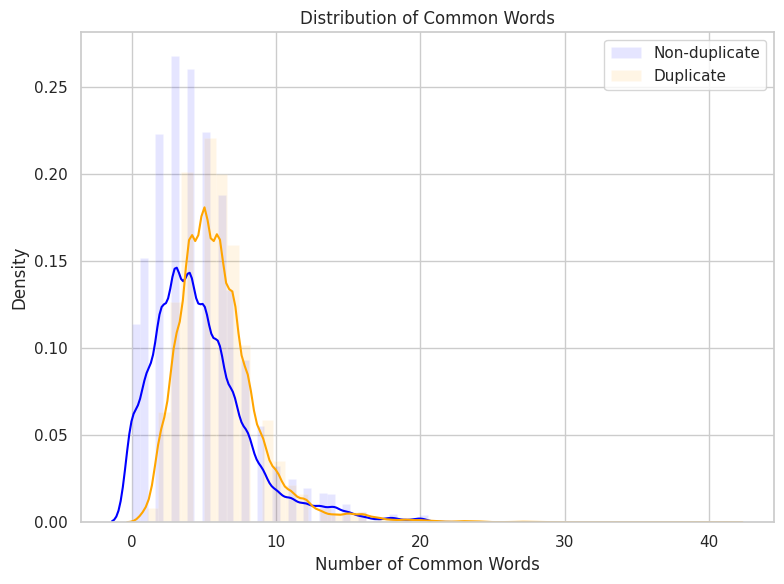

In [32]:
# Set style
sns.set(style="whitegrid")

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the histogram and KDE plot of common words for non-duplicate questions
sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_common'], label='Non-duplicate', color='blue', hist_kws={'alpha': 0.1}, kde=True)

# Plot the histogram and KDE plot of common words for duplicate questions
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_common'], label='Duplicate', color='orange', hist_kws={'alpha': 0.1}, kde=True)

# Add legend
plt.legend()

# Set labels and title
plt.title("Distribution of Common Words")
plt.xlabel("Number of Common Words")
plt.ylabel("Density")

# Show the plot
plt.tight_layout()
plt.show()


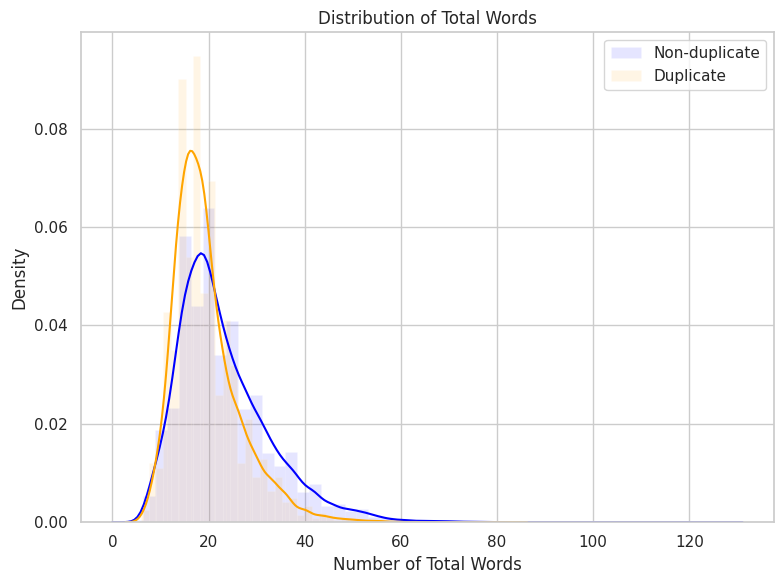

In [33]:
#total words
# Set style
sns.set(style="whitegrid")

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the histogram and KDE plot of total words for non-duplicate questions
sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_total'], label='Non-duplicate', color='blue', hist_kws={'alpha': 0.1}, kde=True)

# Plot the histogram and KDE plot of total words for duplicate questions
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_total'], label='Duplicate', color='orange', hist_kws={'alpha': 0.1}, kde=True)

# Add legend
plt.legend()

# Set labels and title
plt.title("Distribution of Total Words")
plt.xlabel("Number of Total Words")
plt.ylabel("Density")

# Show the plot
plt.tight_layout()
plt.show()


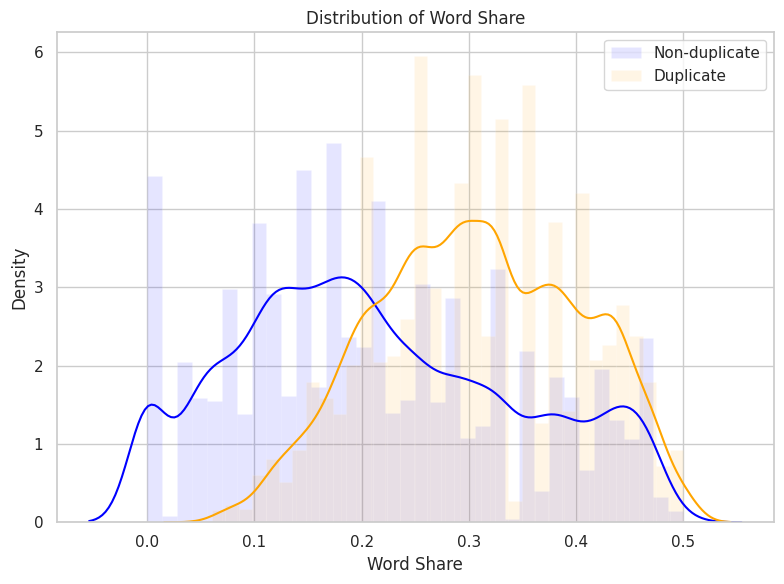

In [34]:
#word share
# Set style
sns.set(style="whitegrid")

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the histogram and KDE plot of word share for non-duplicate questions
sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_share'], label='Non-duplicate', color='blue', hist_kws={'alpha': 0.1}, kde=True)

# Plot the histogram and KDE plot of word share for duplicate questions
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_share'], label='Duplicate', color='orange', hist_kws={'alpha': 0.1}, kde=True)

# Add legend
plt.legend()

# Set labels and title
plt.title("Distribution of Word Share")
plt.xlabel("Word Share")
plt.ylabel("Density")

# Show the plot
plt.tight_layout()
plt.show()


## Advanced Features

### 1. Token Features
- **cwc_min**: This is the ratio of the number of common words to the length of the smaller question
- **cwc_max**: This is the ratio of the number of common words to the length of the larger question
- **csc_min**: This is the ratio of the number of common stop words to the smaller stop word count among the two questions
- **csc_max**: This is the ratio of the number of common stop words to the larger stop word count among the two questions
- **ctc_min**: This is the ratio of the number of common tokens to the smaller token count among the two questions
- **ctc_max**: This is the ratio of the number of common tokens to the larger token count among the two questions
- **last_word_eq**: 1 if the last word in the two questions is same, 0 otherwise
- **first_word_eq**: 1 if the first word in the two questions is same, 0 otherwise

### 2. Length Based Features
- **mean_len**: Mean of the length of the two questions (number of words)
- **abs_len_diff**: Absolute difference between the length of the two questions (number of words)
- **longest_substr_ratio**: Ratio of the length of the longest substring among the two questions to the length of the smaller question

### 3. Fuzzy Features
- **fuzz_ratio**: fuzz_ratio score from fuzzywuzzy
- **fuzz_partial_ratio**: fuzz_partial_ratio from fuzzywuzzy
- **token_sort_ratio**: token_sort_ratio from fuzzywuzzy
- **token_set_ratio**: token_set_ratio from fuzzywuzzy

In [35]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [36]:
# Advanced Features
from nltk.corpus import stopwords

def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features


In [37]:
token_features = new_df.apply(fetch_token_features, axis=1)

new_df["cwc_min"]       = list(map(lambda x: x[0], token_features))
new_df["cwc_max"]       = list(map(lambda x: x[1], token_features))
new_df["csc_min"]       = list(map(lambda x: x[2], token_features))
new_df["csc_max"]       = list(map(lambda x: x[3], token_features))
new_df["ctc_min"]       = list(map(lambda x: x[4], token_features))
new_df["ctc_max"]       = list(map(lambda x: x[5], token_features))
new_df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
new_df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [38]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,word_total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,...,26,0.46,0.874989,0.874989,0.999980,0.999980,0.923070,0.923070,1.0,1.0
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,...,24,0.33,0.666644,0.499988,0.714276,0.624992,0.583328,0.466664,1.0,1.0
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,...,38,0.11,0.000000,0.000000,0.428565,0.272725,0.149999,0.115384,0.0,0.0
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,...,34,0.03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,...,13,0.23,0.749981,0.599988,0.000000,0.000000,0.599988,0.333330,1.0,0.0


In [39]:
!pip install distance -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [40]:
import distance

def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features
    

In [41]:
length_features = new_df.apply(fetch_length_features, axis=1)

new_df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
new_df['mean_len'] = list(map(lambda x: x[1], length_features))
new_df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [42]:
!pip install fuzzywuzzy -q

In [43]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [44]:
fuzzy_features = new_df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
new_df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
new_df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
new_df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
new_df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

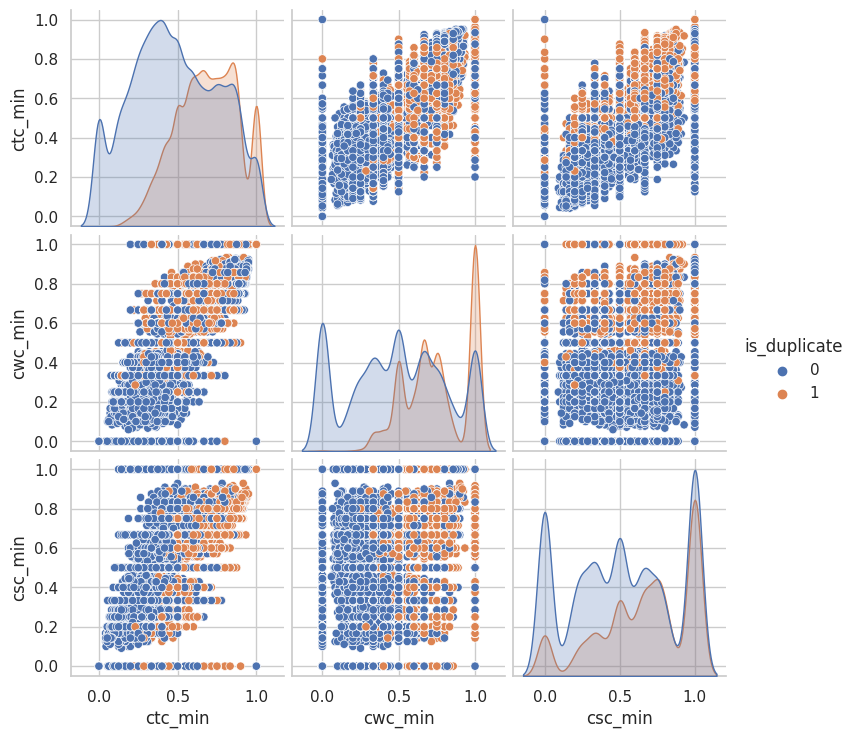

In [45]:
sns.pairplot(new_df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate');

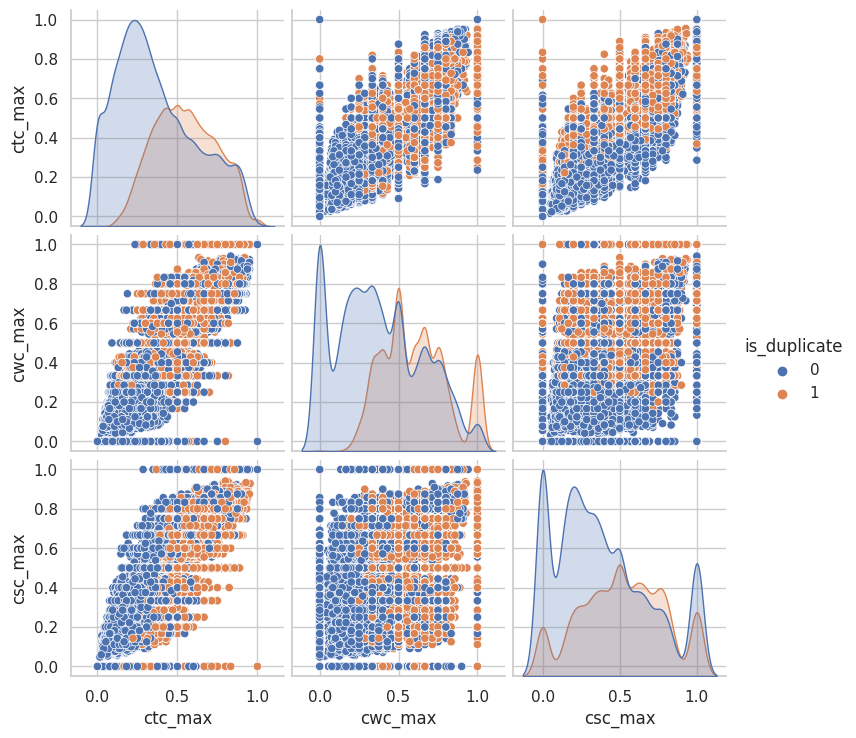

In [46]:
sns.pairplot(new_df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate');

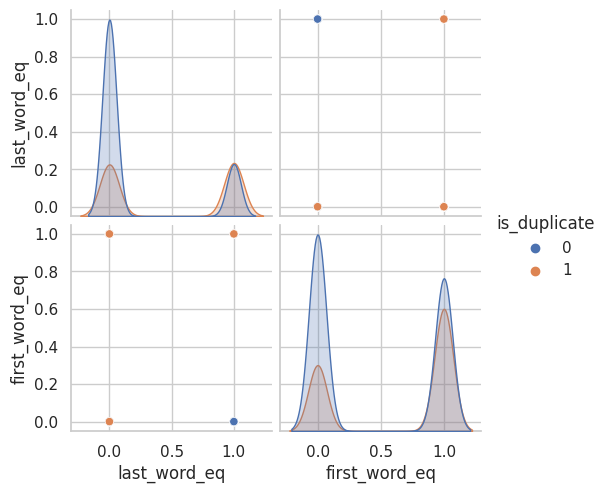

In [47]:
sns.pairplot(new_df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate');

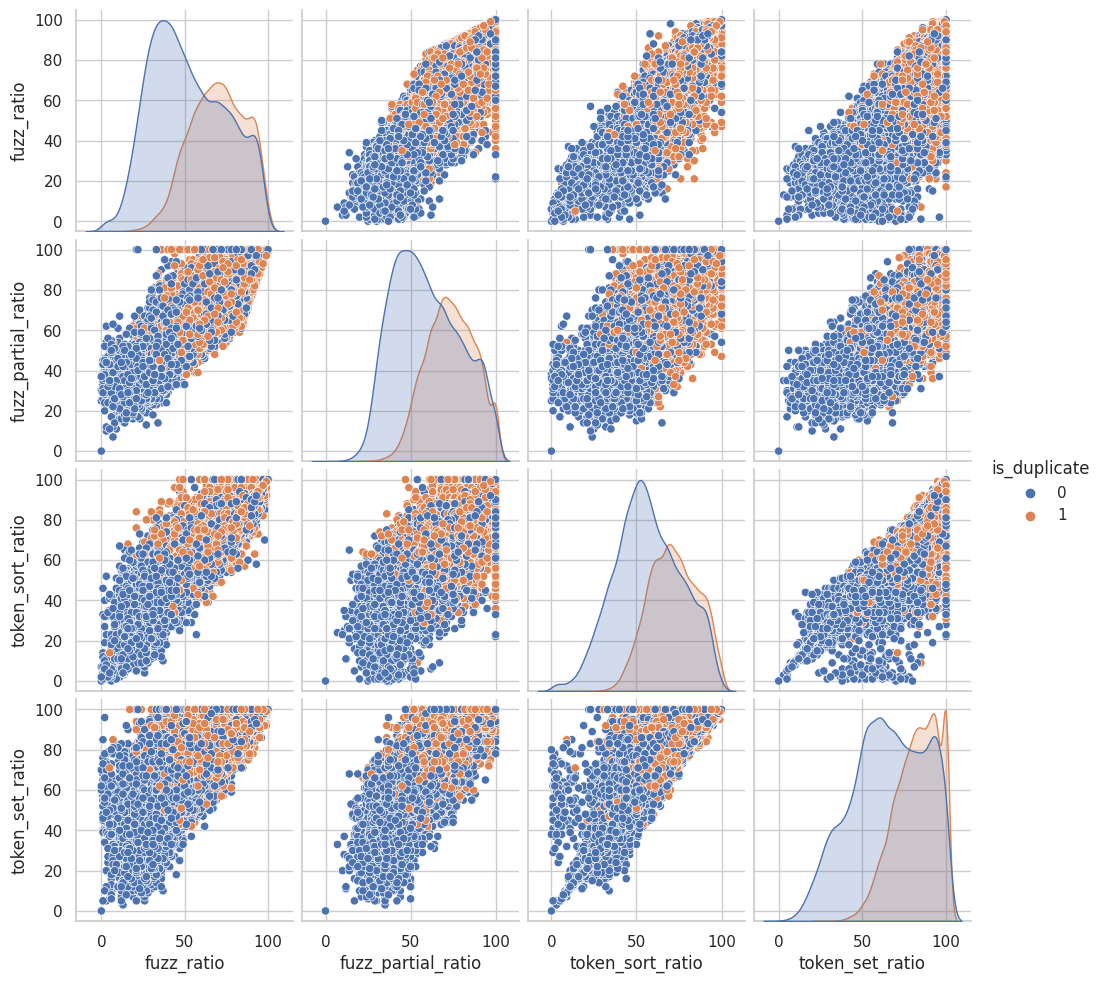

In [48]:
sns.pairplot(new_df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate');

##Experiments

In [ ]:
# create a copy of the dataset
temp_df = new_df.copy()

In [ ]:
temp_df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,...,0.923070,1.0,1.0,0.0,13.0,0.855263,99,99,99,99
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,...,0.466664,1.0,1.0,3.0,13.5,0.224490,69,67,65,74


In [ ]:
# Performing stemming operation 
from nltk.stem import PorterStemmer

# Initialize the PorterStemmer
stemmer = PorterStemmer()

def stem_text(text):
    stemmed_words = [stemmer.stem(word) for word in text.split()]
    return ' '.join(stemmed_words)

# Apply stemming on the 'text' column
temp_df['question1'] = temp_df['question1'].apply(stem_text)
temp_df['question2'] = temp_df['question2'].apply(stem_text)

temp_df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,398782,496695,532029,what is the best market autom tool for small a...,what is the best market autom tool for small a...,1,75,76,13,13,...,0.923070,1.0,1.0,0.0,13.0,0.855263,99,99,99,99
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quit poor and i want to be veri rich what...,0,48,56,13,16,...,0.466664,1.0,1.0,3.0,13.5,0.224490,69,67,65,74


In [ ]:
ques_df = temp_df[['question1','question2']]
ques_df.head()

,question1,question2
398782,what is the best market autom tool for small a...,what is the best market autom tool for small a...
115086,i am poor but i want to invest what should i do,i am quit poor and i want to be veri rich what...
327711,i am from india and live abroad i met a guy fr...,t i e t to thapar univers to thapar univers in...
367788,whi do so mani peopl in the u s hate the south...,my boyfriend doesnt feel guilti when he hurt m...
151235,consequ of bhopal ga tragedi,what wa the reason behind the bhopal ga tragedi


In [ ]:
final_df = temp_df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(30000, 23)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,1,75,76,13,13,12,26,0.46,0.874989,0.874989,...,0.923070,1.0,1.0,0.0,13.0,0.855263,99,99,99,99
115086,0,48,56,13,16,8,24,0.33,0.666644,0.499988,...,0.466664,1.0,1.0,3.0,13.5,0.224490,69,67,65,74
327711,0,104,119,28,21,4,38,0.11,0.000000,0.000000,...,0.115384,0.0,0.0,6.0,23.0,0.047619,26,29,34,43
367788,0,58,145,14,32,1,34,0.03,0.000000,0.000000,...,0.000000,0.0,0.0,17.0,21.5,0.050847,29,41,23,30
151235,0,34,49,5,9,3,13,0.23,0.749981,0.599988,...,0.333330,1.0,0.0,4.0,7.0,0.542857,55,70,48,69


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

tfidf = TfidfVectorizer()
q1_arr, q2_arr = np.vsplit(tfidf.fit_transform(questions).toarray(),2)

In [ ]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)

In [ ]:
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)

In [ ]:
# stemp_df = pd.concat([temp_df1, temp_df2], axis=1)
# temp_df.shape

In [ ]:
!pip install vaex -q

In [ ]:
import vaex

# Convert the Pandas DataFrame to Vaex DataFrame
temp_df1_vaex = vaex.from_pandas(temp_df1)

In [ ]:
temp_df2_vaex = vaex.from_pandas(temp_df2)

In [ ]:
temp_df1_vaex.export_hdf5('temp_df1.hdf5')

In [ ]:
temp_df2_vaex.export_hdf5('temp_df2.hdf5')

In [ ]:
import vaex
temp_df1_vaex = vaex.open("temp_df1.hdf5")
temp_df2_vaex = vaex.open("temp_df2.hdf5")

In [ ]:
temp_df1_vaex.shape

(30000, 1642)

In [ ]:
# Concatenate the two Vaex DataFrames along the row axis
concatenated_df = vaex.concat([temp_df1_vaex, temp_df2_vaex])

In [ ]:
concatenated_df.export_hdf5('temp.hdf5')

In [ ]:
final_df_vaex = vaex.from_pandas(final_df)

In [ ]:
final_df_vaex.export_hdf5("final_df.hdf5")

In [ ]:
import vaex
vaex_df = vaex.open('temp.hdf5')

In [ ]:
import vaex
final_df = vaex.open("final_df.hdf5")

In [ ]:
temp_df=vaex.open("temp.hdf5")

In [ ]:
final_df = vaex.concat([final_vaex_df, temp_df])

In [ ]:
import vaex.ml

# Split the Vaex DataFrame into train and test datasets
train_df, test_df = final_df.ml.train_test_split(test_size=0.2)

/usr/local/lib/python3.10/dist-packages/vaex/ml/__init__.py:28: UserWarning: Make sure the DataFrame is shuffled
  warnings.warn('Make sure the DataFrame is shuffled')


In [ ]:
import vaex
from sklearn.ensemble import RandomForestClassifier

# Create a RandomForestClassifier object.
clf = RandomForestClassifier()

features = list(final_df.columns)[1:]
target = list(final_df.columns)[0]

# Fit the model to the train set.
clf.fit(train_df[features], train_df[target].to_numpy().reshape(-1, 1))

# Evaluate the model on the test set.
score = clf.score(test_df[features], test_df[target].to_numpy().reshape(-1, 1))

# Get the predictions from the model.
predictions = clf.predict(test_df[features])

# Create the confusion matrix.
confusion_matrix = confusion_matrix(test_df[target].to_numpy().reshape(-1, 1), predictions.reshape(-1, 1))

print("Score:", score)

# Print the confusion matrix.
print(confusion_matrix)

<ipython-input-32-32454bf9314a>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(train_df[features], train_df[target].to_numpy().reshape(-1, 1))


TypeError: ignored

In [ ]:
import vaex
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Create a RandomForestClassifier object.
clf = RandomForestClassifier()

features = list(final_df.columns)[1:]
target = list(final_df.columns)[0]

# Fit the model to the train set.
clf.fit(train_df[features], train_df[target].to_numpy().reshape(-1, 1))

# Evaluate the model on the test set.
score = clf.score(test_df[features], test_df[target].to_numpy().reshape(-1, 1))

# Get the predictions from the model.
predictions = clf.predict(test_df[features])

# Create the confusion matrix.
cm = confusion_matrix(test_df[target].to_numpy().reshape(-1, 1), predictions.reshape(-1, 1))

print("Score:", score)

# Print the confusion matrix.
print(cm)


<ipython-input-33-4f86ca2e33a9>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(train_df[features], train_df[target].to_numpy().reshape(-1, 1))


Score: 0.7463333333333333
[[3047  759]
 [ 763 1431]]


In [ ]:
import vaex
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Create a RandomForestClassifier object.
clf = RandomForestClassifier()

features = list(final_df.columns)[1:]
target = list(final_df.columns)[0]

# Fit the model to the train set.
clf.fit(train_df[features], train_df[target].to_numpy().reshape(-1))

# Evaluate the model on the test set.
score = clf.score(test_df[features], test_df[target].to_numpy().reshape(-1))

# Get the predictions from the model.
predictions = clf.predict(test_df[features])

# Create the confusion matrix.
cm = confusion_matrix(test_df[target].to_numpy().reshape(-1), predictions)

print("Score:", score)

# Print the confusion matrix.
print(cm)


Score: 0.7478333333333333
[[3031  775]
 [ 738 1456]]


In [ ]:
import vaex
import xgboost as xgb
from sklearn.metrics import confusion_matrix

# Create an XGBClassifier object.
clf = xgb.XGBClassifier()

features = list(final_df.columns)[1:]
target = list(final_df.columns)[0]

# Fit the model to the train set.
clf.fit(train_df[features], train_df[target].to_numpy().reshape(-1))

# Evaluate the model on the test set.
score = clf.score(test_df[features], test_df[target].to_numpy().reshape(-1))

# Get the predictions from the model.
predictions = clf.predict(test_df[features])

# Create the confusion matrix.
confusion_matrix = confusion_matrix(test_df[target].to_numpy().reshape(-1), predictions)

print("Score:", score)

# Print the confusion matrix.
print(confusion_matrix)

Score: 0.746
[[3028  778]
 [ 746 1448]]


In [ ]:
from tqdm.notebook import tqdm 

for i in tqdm(features):
  if train_df[str(i)].dtype == 'int64':
    train_df[str(i)] = train_df[str(i)].astype('float32')

  0%|          | 0/22 [00:00<?, ?it/s]

## Applying cross validation

In [ ]:
import vaex
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

# Create a RandomForestClassifier object.
clf = RandomForestClassifier()

features = list(final_df.columns)[1:]
target = list(final_df.columns)[0]

# Evaluate the model using cross-validation.
cv_scores = cross_val_score(clf, final_df[features].values, final_df[target].values, cv=5)

# Get the average score and standard deviation of the scores.
average_score = cv_scores.mean()
std_deviation = cv_scores.std()

print("Cross-Validation Scores:", cv_scores)
print("Average Score:", average_score)
print("Standard Deviation:", std_deviation)

# Fit the model to the train set.
clf.fit(train_df[features].values, train_df[target].values)

# Evaluate the model on the test set.
score = clf.score(test_df[features].values, test_df[target].values)

# Get the predictions from the model.
predictions = clf.predict(test_df[features].values)

# Create the confusion matrix.
cm = confusion_matrix(test_df[target].values, predictions)

print("Score:", score)
print("Confusion Matrix:")
print(cm)


Cross-Validation Scores: [0.74583333 0.746      0.75183333 0.74816667 0.74616667]
Average Score: 0.7476
Standard Deviation: 0.0022793761329705084
Score: 0.7495
Confusion Matrix:
[[3057  749]
 [ 754 1440]]


In [ ]:
import vaex
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

# Create a RandomForestClassifier object.
clf = RandomForestClassifier()

features = list(final_df.columns)[1:]
target = list(final_df.columns)[0]

# Define the parameter grid for random search.
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a RandomizedSearchCV object.
random_search = RandomizedSearchCV(clf, param_distributions=param_grid, cv=5, n_iter=10)

# Perform the random search cross-validation.
random_search.fit(final_df[features].values, final_df[target].values)

# Get the best estimator and its score.
best_estimator = random_search.best_estimator_
best_score = random_search.best_score_

print("Best Estimator:", best_estimator)
print("Best Score:", best_score)

# Fit the best estimator to the train set.
best_estimator.fit(train_df[features].values, train_df[target].values)

# Evaluate the best estimator on the test set.
score = best_estimator.score(test_df[features].values, test_df[target].values)

# Get the predictions from the best estimator.
predictions = best_estimator.predict(test_df[features].values)

# Create the confusion matrix.
cm = confusion_matrix(test_df[target].values, predictions)

# print("Score:", score)
print("Confusion Matrix:")
print(cm)


Best Estimator: RandomForestClassifier(min_samples_leaf=4, n_estimators=300)
Best Score: 0.7524333333333333
Score: 0.7501666666666666
Confusion Matrix:
[[3030  776]
 [ 723 1471]]


In [ ]:
import vaex
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

# Create an XGBClassifier object.
clf = xgb.XGBClassifier()

features = list(final_df.columns)[1:]
target = list(final_df.columns)[0]

# Define the parameter grid for random search.
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Create a RandomizedSearchCV object.
random_search = RandomizedSearchCV(clf, param_distributions=param_grid, cv=5, n_iter=10)

# Perform the random search cross-validation.
random_search.fit(train_df[features], train_df[target].to_numpy().reshape(-1))

# Get the best estimator and its score.
best_estimator = random_search.best_estimator_
best_score = random_search.best_score_

print("Best Estimator:", best_estimator)
print("Best Score:", best_score)

# Evaluate the best estimator on the test set.
score = best_estimator.score(test_df[features], test_df[target].to_numpy().reshape(-1))

# Get the predictions from the best estimator.
predictions = best_estimator.predict(test_df[features])

# Create the confusion matrix.
cm = confusion_matrix(test_df[target].to_numpy().reshape(-1), predictions)

# print("Score:", score)
print("Confusion Matrix:")
print(cm)
